In [1]:
# Use OpenPIV to know where you re
import openpiv.tools
import openpiv.process
import openpiv.scaling
import openpiv.validation
import openpiv.filters
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# prepare the images from the online GIF
gifurl = 'http://31.media.tumblr.com/bcf3ac1221295f26eb55ac1d14c74ca6/tumblr_mpky2xhSZf1qipfmqo1_500.gif'
from IPython import display
i = display.Image(url=gifurl)

In [3]:
# Convert the GIF into a set of PNG files
from PIL import Image
import urllib2 as urllib
from StringIO import StringIO

fd = urllib.urlopen(gifurl)
im = Image.open(StringIO(fd.read()))
# imshow(im,cmap=cm.gray)

In [4]:
def processImage(im):
    i = 0
    mypalette = im.getpalette()
    imgSize = im.size

    try:
        while 1:
            img = im.convert('L')
            img.save('foo'+str(i)+'.png')
            i += 1
            im.seek(im.tell() + 1)

    except EOFError:
        pass # end of sequence

processImage(im)

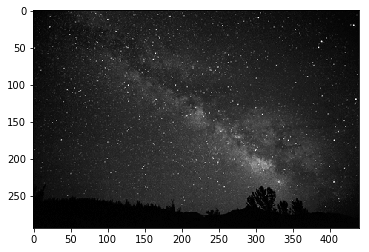

In [5]:
# Show the image in greyscale
imshow(imread('foo0.png'),cmap=cm.gray) 

In [6]:
imfiles = !ls *.png
imfiles
# We'll process every image with the next one:
for i,f in enumerate(imfiles[:-1]):
    print f
    print imfiles[i+1]

foo0.png
foo1.png
foo1.png
foo2.png
foo2.png
foo3.png
foo3.png
foo4.png
foo4.png
foo5.png
foo5.png
foo6.png
foo6.png
foo7.png
foo7.png
foo8.png
foo8.png
foo9.png


In [7]:
# PIV settings
window_size = 64 # pixels
overlap = 32 # pixels, i.e. 50%
dt = 1.0 #



# the main loop: estimate flow using PIV cross-correlation, filter, interpolate and plot
for i,f in enumerate(imfiles[:-1]):
    # process PIV
    img_a = np.int32(imread(f)*255)
    img_b = np.int32(imread(imfiles[i+1])*255)
    
    
    u, v, sig2noise = \
    openpiv.process.extended_search_area_piv( \
                                         img_a,img_b, \
                                         window_size=window_size,\
                                         overlap = overlap, \
                                         dt = dt, \
                                         search_area_size = window_size, \
                                         sig2noise_method = 'peak2peak' )

    # get the central points of the interrogation windows
    x, y = openpiv.process.get_coordinates( image_size = img_a.shape, \
                                       window_size = window_size, \
                                       overlap  = overlap )
    # peak to peak ratio to mask errorneous vectors is about 1.1 - 1.3
    u, v, mask = openpiv.validation.sig2noise_val( u, v, sig2noise, threshold = 1.1 )
    # Replace outliers (masked in the previous step) using the local mean filter:
    u, v = openpiv.filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
    # rescale the data from pixel/dt into mm/sec
    x, y, u, v = openpiv.scaling.uniform(x, y, u, v, scaling_factor = 1.0 )
    # print x,y,u,v,sig2noise
    # save the result if you need or show it in a plot (see below):
    openpiv.tools.save(x, y, u, v, mask, 'foo'+str(i)+'.txt' )

    # openpiv.tools.display_vector_field('foo'+str(i)+'.txt', scale=100, width=0.0025)
    # Show the vectof flow field using vertical velocity for the color mapping
    


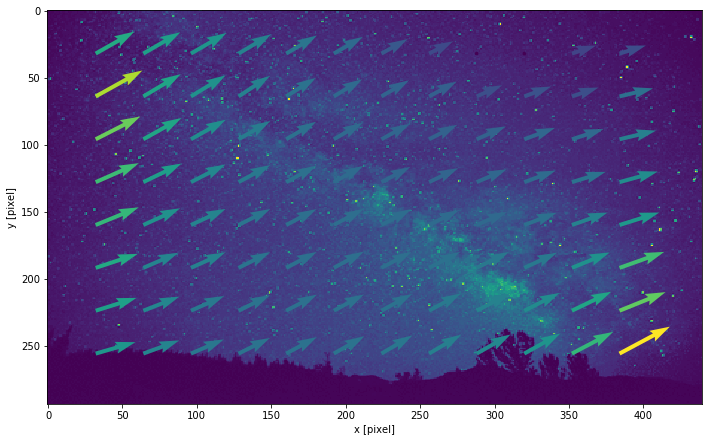

In [8]:
# Graphics settings
fig, ax = subplots(figsize=(10,10))
ax.imshow(imread(imfiles[0]))
ax.quiver(x,y,u,v,u**2+v**2)
ax.set_xlabel('x [pixel]')
ax.set_ylabel('y [pixel]')
tight_layout()
ax.set_aspect(.9)